### 0. Importing and loading the data


In [65]:
# importing packages
import json
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import statistics
import time
from calendar import monthrange

In [66]:
# importing commit data of bitcoin, numpy, react projects on github
with open('bitcoin_commits.json') as f:
    bitcoin_data = json.load(f)
with open('numpy_commits.json') as f:
    numpy_data = json.load(f)
with open('react_commits.json') as f:
    react_data = json.load(f)

In [67]:
# creating pandas dataframe from the loaded files
bitcoin_df = pd.DataFrame(bitcoin_data)
numpy_df = pd.DataFrame(numpy_data)
react_df = pd.DataFrame(react_data)

### 1. Preprocessing the data
1. change the time from seconds to datetime
2. sort the array by commit time
3. create a field "month"

In [68]:
# 1. Changing the time from seconds to the datetime 
# Run this only once (when first loading the data)
bitcoin_df["committer_time"] = [datetime.datetime.fromtimestamp(i/1000.0) for i in bitcoin_df["committer_time"]]
numpy_df["committer_time"] = [datetime.datetime.fromtimestamp(i/1000.0) for i in numpy_df["committer_time"]]
react_df["committer_time"] = [datetime.datetime.fromtimestamp(i/1000.0) for i in react_df["committer_time"]]

In [69]:
# 2. Sorting by time
numpy_df = numpy_df.sort_values(by=['committer_time'])
bitcoin_df = bitcoin_df.sort_values(by=['committer_time'])
react_df = react_df.sort_values(by=['committer_time'])

In [70]:
# 3. Creating the field "month"
numpy_df["month"]=[100*i.year+i.month for i in numpy_df["committer_time"]]
react_df["month"]=[100*i.year+i.month for i in react_df["committer_time"]]
bitcoin_df["month"]=[100*i.year+i.month for i in bitcoin_df["committer_time"]]

### 2. Preliminary information about the projects

In [71]:
index = ['bitcoin', 'numpy', 'react']
column = ['number of commits', 'number of contributors', 'first date', 'last date']

In [72]:
b_num_commit = bitcoin_df.shape[0]
n_num_commit = numpy_df.shape[0]
r_num_commit = react_df.shape[0]

In [73]:
b_num_cont = len(set(bitcoin_df["author_name"]))
n_num_cont = len(set(numpy_df["author_name"]))
r_num_cont = len(set(react_df["author_name"]))

In [74]:
b_start = bitcoin_df['committer_time'][0]
n_start = numpy_df['committer_time'][0]
r_start = react_df['committer_time'][0]

In [75]:
b_last_list = list(bitcoin_df['committer_time'])
b_last_list.sort()
n_last_list = list(numpy_df['committer_time'])
n_last_list.sort()
r_last_list = list(react_df['committer_time'])
r_last_list.sort()

In [76]:
projects = pd.DataFrame([[b_num_commit,b_num_cont,b_start,b_last_list[-1]],\
                         [n_num_commit,n_num_cont,n_start,b_last_list[-1]],\
                         [r_num_commit,r_num_cont,r_start,b_last_list[-1]]],index=index,columns=column)
projects

,number of commits,number of contributors,first date,last date
bitcoin,36302,1210,2009-08-29 23:46:39,2018-01-18 10:05:40
numpy,24552,937,2001-12-18 10:45:10,2018-01-18 10:05:40
react,24157,2138,2013-05-29 08:54:02,2018-01-18 10:05:40


### 3. Options for picking the dividing point
1. largest number of new contributors
2. largest increase in the number of contributors

In [77]:
def pick_div(df):
    '''
    return the dividing point in time between old and new contributors
    i.e the month with the largest number of new contributors
    '''
    months = list(set(df['month']))
    months.sort()
    div_month = 0
    largest = 0
    old_users = set()
    for i in months:
        is_month_i = df[df["month"]==i]
        curr_month_users = set(is_month_i["committer_name_dedup"])
        new_users = curr_month_users - old_users
        old_users = old_users.union(new_users)
        if len(new_users) > largest:
            largest = len(new_users)
            div_month = i
        prev_month = len(curr_month_users)
    return div_month

In [78]:
def pick_div2(df):
    '''
    return the dividing point in time between old and new contributors
    i.e the month with the largest increase in the number of contributors
    '''
    months = list(set(df['month']))
    months.sort()
    prev_month = 0
    div_month = 0
    largest_jump = 0
    for i in months:
        is_month_i = df[df["month"]==i]
        diff = len(set(is_month_i["committer_name_dedup"])) - prev_month
        if diff > largest_jump:
            largest_jump = diff
            div_month = i
        prev_month = len(set(is_month_i["committer_name_dedup"]))
    return div_month

In [83]:
print("Numpy's diving point using the first method of picking the dividing point is {}".format(pick_div(numpy_df)))
print("Numpy's diving point using the second method of picking the dividing point is {}".format(pick_div2(numpy_df)))
print("React's diving point using the first method of picking the dividing point is {}".format(pick_div(react_df)))
print("React's diving point using the second of picking the dividing point is {}".format(pick_div2(react_df)))
print("Bitcoin's diving point using the first method of picking the dividing point is {}".format(pick_div(bitcoin_df)))
print("Bitcoin's diving point using the second of picking the dividing point is {}".format(pick_div2(bitcoin_df)))

Numpy's diving point using the first method of picking the dividing point is 201601
Numpy's diving point using the second method of picking the dividing point is 201510
React's diving point using the first method of picking the dividing point is 201510
React's diving point using the second of picking the dividing point is 201510
Bitcoin's diving point using the first method of picking the dividing point is 201403
Bitcoin's diving point using the second of picking the dividing point is 201403


##### Findings
1. Looks like the two methods are returning almost identical month proving that they are good identifier of the dividing point

### 4. Visualizing the dividing point

In [29]:
def vis_div(df):
    '''
    visualize the dividing point
    '''
    months = set(df['month'])
    months = list(months)
    months.sort()
    month_dict = {}
    for i in months:
        is_month_i = df[df["month"]==i]
        month_dict[i]=len(set(is_month_i["committer_name_dedup"]))
    plt.ylabel('Number of new contributors')
    plt.xlabel('YearMonth')
    plt.plot(list(month_dict.keys()),list(month_dict.values()))

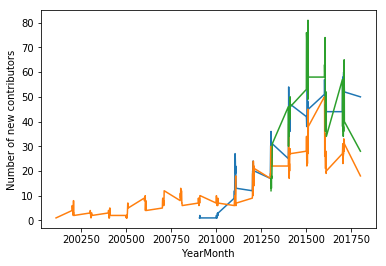

In [30]:
vis_div(bitcoin_df)
vis_div(numpy_df)
vis_div(react_df)

### 5. Find the old users

In [56]:
def old_users(df):
    '''
    return the Pandas dataframe of commits done only by the old users
    '''
    div = pick_div(df)
    s = set(df['author_name'])
    old_users = []
    for a in s:
        a_df = df[df['author_name'] == a]
        a_commit_time_list = list(a_df["committer_time"])
        a_commit_time_list.sort()
        first = a_commit_time_list[0]
        first = str(first.year) + '' + str(first.month) if first.month >= 10 else str(first.year) + '0' + str(first.month)
        if int(first) >= div:
            continue
        old_users.append(a)
    return df[df['author_name'].isin(old_users)]

In [57]:
numpy_old_df = old_users(numpy_df)
react_old_df = old_users(react_df)
bitcoin_old_df = old_users(bitcoin_df)

In [58]:
def old_after_div(df):
    '''
    Returns the dataframe containing the commits by the old users after the dividing point
    '''
    div = pick_div(df)
    div_year = int(str(div)[:4])
    div_month = int(str(div)[-2:])
    div_day = monthrange(div_year, div_month)[1]
    div = datetime.datetime(div_year, div_month, div_day)
    old_df = old_users(df)
    after_div_df = old_df[old_df['committer_time'] > div]
    return after_div_df

In [59]:
n_old_after_div_df = old_after_div(numpy_df)
r_old_after_div_df = old_after_div(react_df)
b_old_after_div_df = old_after_div(bitcoin_df)

In [60]:
print("Numpy's number of old users is {}".format(len(set(numpy_old_df['author_name']))))
print("React's number of old users is {}".format(len(set(react_old_df['author_name']))))
print("Bitcoin's number of old users is {}".format(len(set(bitcoin_old_df['author_name']))))

Numpy's number of old users is 597
React's number of old users is 826
Bitcoin's number of old users is 352


In [61]:
print("Numpy's number of old users contributing after the dividing point is {}".format(len(set(n_old_after_div_df['author_name']))))
print("React's number of old users contributing after the dividing point is {}".format(len(set(r_old_after_div_df['author_name']))))
print("Bitcoin's number of old users contributing after the dividing point is {}".format(len(set(b_old_after_div_df['author_name']))))

Numpy's number of old users contributing after the dividing point is 128
React's number of old users contributing after the dividing point is 94
Bitcoin's number of old users contributing after the dividing point is 61


##### Findings
1. Seems like most old contributors leave the project before the project becomes popular! 


### 6. How long do the older users stick around?

In [62]:
def stick_around(df):
    '''
    return 1. the median start date of the old user 
           2. the median last date of the old user
           #3. the median length of time the old user stuck around after the div
    in 3-tuple form (1, 2, 3)
    '''
    div = pick_div(df)
    s = set(df['author_name'])
    n_div = pick_div(df)
    firsts = []
    lasts = []
    for a in s:
        a_df = df[df['author_name'] == a]
        a_commit_time_list = list(a_df["committer_time"])
        a_commit_time_list.sort()
        first = a_commit_time_list[0]
        first_div_format = str(first.year) + '' + str(first.month) if first.month >= 10 else str(first.year) + '0' + str(first.month)
        if int(first_div_format) >= n_div:
            continue
        last  = a_commit_time_list[-1]
        first_int = int(time.mktime(first.timetuple()))
        last_int = int(time.mktime(last.timetuple()))
        firsts.append(first_int)
        lasts.append(last_int)
    first_med = statistics.median(firsts)
    last_med = statistics.median(lasts)
#    after_div = statistics.median(firsts)
    return (datetime.datetime.fromtimestamp(first_med), datetime.datetime.fromtimestamp(last_med))


In [63]:
stick_around(react_df)

(datetime.datetime(2014, 11, 30, 22, 17, 50, 500000),
 datetime.datetime(2015, 2, 7, 10, 38, 1))

In [56]:
x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.show()

NameError: name 'lists' is not defined

In [70]:
import collections

In [71]:
collections.OrderedDict

collections.OrderedDict

In [63]:
numpy_df[numpy_df['month'] == "2001-12"]

,age,author_email,author_email_dedup,author_name,author_name_dedup,author_time,committer_email,committer_email_dedup,committer_name,committer_name_dedup,...,delay,id,ismerge,loc_d,loc_i,message,ndiffs,nfiles,squashof,month
0,-1,e***@enthought.com,e***@enthought.com,Eric Jones,Eric Jones,2001-12-18 10:45:10,e***@enthought.com,e***@enthought.com,Eric Jones,Eric Jones,...,0,f1a2d6376c430f65550efa235209b86c1a0967e3,False,0,1337,factored out the scipy specific distutils code...,1,14,-1,2001-12
1,-1,e***@enthought.com,e***@enthought.com,Eric Jones,Eric Jones,2001-12-25 01:03:41,e***@enthought.com,e***@enthought.com,Eric Jones,Eric Jones,...,0,74a4958b94e07b2e3218741fb52d32e87308d62e,False,0,303,split scipy_test off into its own module.\n,1,3,-1,2001-12
2,-1,e***@enthought.com,e***@enthought.com,Eric Jones,Eric Jones,2001-12-25 01:05:32,e***@enthought.com,e***@enthought.com,Eric Jones,Eric Jones,...,0,a76efe8206df0ec315f67012236577c1e31ad258,False,1,29,added build_py module\n,1,3,-1,2001-12
3,-1,e***@enthought.com,e***@enthought.com,Eric Jones,Eric Jones,2001-12-25 01:06:40,e***@enthought.com,e***@enthought.com,Eric Jones,Eric Jones,...,0,76cfe839f027edd48a86112bc8e1490d848d20d0,False,37,102,added misc_util file that has a few routines u...,1,5,-1,2001-12
4,-1,e***@enthought.com,e***@enthought.com,Eric Jones,Eric Jones,2001-12-31 03:40:02,e***@enthought.com,e***@enthought.com,Eric Jones,Eric Jones,...,0,b1263a71669aad6b9ac5db8ce961a18c204e925f,False,1,128,fixed path issues resulting from using setup_x...,1,2,-1,2001-12
5,-1,e***@enthought.com,e***@enthought.com,Eric Jones,Eric Jones,2001-12-31 03:52:45,e***@enthought.com,e***@enthought.com,Eric Jones,Eric Jones,...,0,806417f9f8b3c3a2414362b0ee69684a7afe58cb,False,0,14,added package_config method to misc_util that ...,1,1,-1,2001-12
6,-1,e***@enthought.com,e***@enthought.com,Eric Jones,Eric Jones,2001-12-31 03:54:57,e***@enthought.com,e***@enthought.com,Eric Jones,Eric Jones,...,0,8d4cc5e1967f6b20e69158e5a2700aecc50d46e2,False,1,1,added default setting so users don't need to s...,1,1,-1,2001-12
7,-1,e***@enthought.com,e***@enthought.com,Eric Jones,Eric Jones,2001-12-31 04:13:38,e***@enthought.com,e***@enthought.com,Eric Jones,Eric Jones,...,0,d1d33442a918c2ec4b90dc5f777397e021cd10d1,False,6,0,removed print statements\n,1,1,-1,2001-12


In [ ]:
# read the entire file into a python array
with open('C:/Users/Alberto/nutrients.json', 'rb') as f:
   data = f.readlines()

# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip(), data)

# each element of 'data' is an individual JSON object.
# i want to convert it into an *array* of JSON objects
# which, in and of itself, is one large JSON object
# basically... add square brackets to the beginning
# and end, and have all the individual business JSON objects
# separated by a comma
data_json_str = "[" + ",".join(data) + "]"

# now, load it into pandas
data_df = pd.read_json(data_json_str)